[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanharvey1/neuro_py/blob/main/tutorials/decoding.ipynb)
&nbsp;
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ryanharvey1/neuro_py/main/tutorials/decoding.ipynb)
&nbsp;
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanharvey1/neuro_py/main?labpath=tutorials%2Fdecoding.ipynb)

# Neural Decoding

In this tutorial, we'll explore how to use the Deep Neural Network decoders in
[`decoding`](https://ryanharvey1.github.io/neuro_py/reference/neuro_py/ensemble/decoding/)
submodule to analyze the neural correlates of behavior.

We will begin with synthetic data generation, followed by training and
evaluating models on real neural data. The goal is to understand how neural
activity can be decoded to predict behavioral outcomes.

---

## Setup

First, let's import the necessary libraries and set up our environment.

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
import logging
import random

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import neuro_py as npy
import nelpy as nel
import ratinabox as rbx
import ipywidgets as widgets

from ratinabox.Neurons import PlaceCells

# Disable logging
logger = logging.getLogger()
logger.disabled = True

### Set device and random seed for reproducibility

In [2]:
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2**32 - 1)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True

    print(f"Random seed {seed} has been set.")
    return seed


def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled.")
    else:
        print("GPU is enabled.")

    return device


SEED = set_seed(2025)
DEVICE = set_device()

Random seed 2025 has been set.
GPU is enabled.


## Section 1: Decode Synthetic Neural Data

### Section 1.1: Generate Synthetic Data

#### Section 1.1.1: Create Environment

The following function generates a cheeseboard-inspired maze environment for the
agent:

In [3]:
def create_cheeseboard_maze(
    radius=6.8, nrewards=3, nwellsonaxis=17, nseparationunits=4
):
    """
    Creates a cheeseboard-inspired maze using RatInABox with a circular environment
    and a grid of navigable positions.
    """
    # make a bulb shaped boundary
    environment = rbx.Environment(
        params=dict(
            boundary=[
                [0.5 * np.cos(t), 0.5 * np.sin(t)]
                for t in np.linspace(0, 2 * np.pi, 100)
            ],
            boundary_conditions="solid",
            dimensionality="2D",
        )
    )

    # Generate the grid of positions
    x = np.linspace(-radius * 1.03, radius * 1.03, nwellsonaxis)
    y = np.linspace(-radius * 1.03, radius * 1.03, nwellsonaxis)
    X, Y = np.meshgrid(x, y)
    grid_positions = np.vstack([X.flatten(), Y.flatten()]).T
    separationunit = np.sqrt((x[1] - x[0]) ** 2 + (y[1] - y[0]) ** 2)

    # Filter positions to stay within the circle
    circle_mask = (X**2 + Y**2) <= radius**2
    grid_positions_within_circle = grid_positions[circle_mask.flatten()]

    # Randomly pick 3 points with a minimum separation
    def pick_random_points(points, num_points=3, min_dist=4):
        chosen_points = []
        chosen_points_indices = []
        while len(chosen_points) < num_points:
            candidate_idx = np.random.choice(len(points))
            candidate = points[candidate_idx]
            if all(np.linalg.norm(candidate - p) >= min_dist for p in chosen_points):
                chosen_points.append(candidate)
                chosen_points_indices.append(candidate_idx)
        return np.array(chosen_points_indices)

    reward_indices = pick_random_points(
        grid_positions_within_circle,
        num_points=nrewards,
        min_dist=separationunit * nseparationunits,
    )

    # add wells
    for i, gp in enumerate(grid_positions_within_circle):
        environment.add_object(gp / (radius * 2))

    return environment, reward_indices


environment, reward_indices = create_cheeseboard_maze()

#### Section 1.1.2: Create Agent and Place Cells encoding agent's position

    • To AUTOMATICALLY save all plots (recommended), set  `ratinabox.autosave_plots = True`
    • To MANUALLY save plots, call                        `ratinabox.utils.save_figure(figure_object, save_title).
      This warning will not be shown again
HINT: You can stylize plots to make them look like repo/paper by calling `ratinabox.stylize_plots()`
      This hint will not be shown again


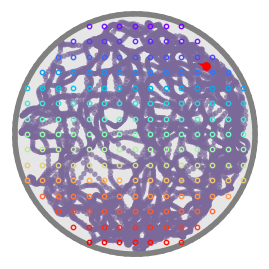

In [4]:
agent = rbx.Agent(environment)

N_NEURONS = 10
TIME = 10
bins = int(TIME * 60 / agent.dt)
placecells = PlaceCells(
    agent,
    params=dict(
        description="gaussian_threshold",
        widths=0.3,
        n=N_NEURONS,
        color="C1",
        wall_geometry="line_of_sight",
    ),
)

# simulate the agent in the maze
for i in range(bins):
    agent.update()
    placecells.update()

agent.plot_trajectory();

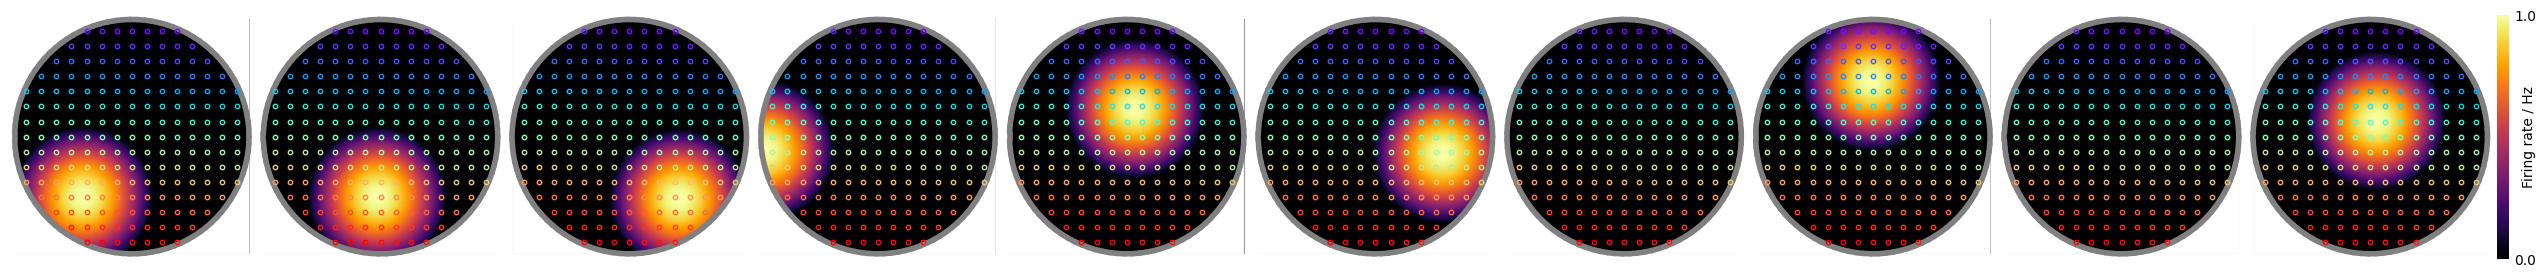

In [5]:
fig, ax = placecells.plot_rate_map(chosen_neurons="all")

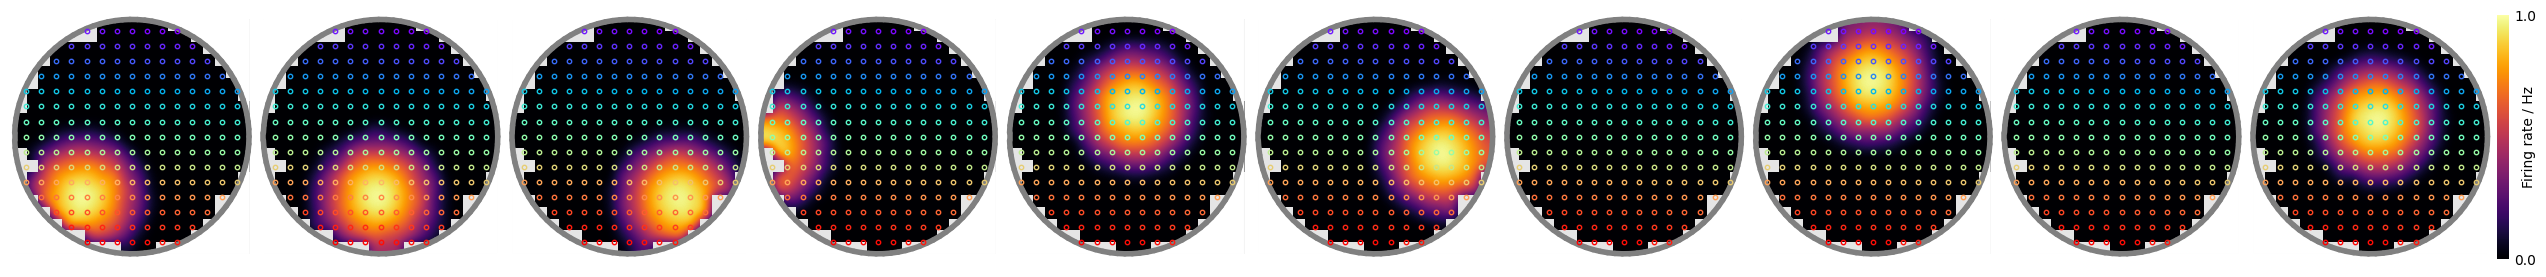

In [6]:
placecells.plot_rate_map(method="history");

### Section 1.2: Prepare Data for Decoding

Extract firing rates from the place cells and the agent's positional trajectory

In [7]:
t_start = 0.0  # seconds
t_end = bins
t = np.array(placecells.history["t"])
i_start = 0 if t_start is None else np.argmin(np.abs(t - t_start))
i_end = -1 if t_end is None else np.argmin(np.abs(t - t_end))
t = t[i_start:i_end]  # subsample data for training (most of it is redundant anyway)
neural_data = np.array(placecells.history["firingrate"])[i_start:i_end]
trajectory = np.array(placecells.Agent.history["pos"])[i_start:i_end]

Format the neural data and behavioral variables (here, position) for decoding:

In [8]:
# Convert neural data and trajectory into training format
neural_data_df = pd.DataFrame(neural_data)  # Neural data as DataFrame
predict_bv = ["x", "y"]
trajectory_df = pd.DataFrame(trajectory, columns=predict_bv)  # Positions

# Split into training and testing sets (e.g., 80% train, 20% test)
split_idx = int(0.8 * len(neural_data_df))
train_neural, test_neural = neural_data_df[:split_idx], neural_data_df[split_idx:]
train_trajectory, test_trajectory = trajectory_df[:split_idx], trajectory_df[split_idx:]

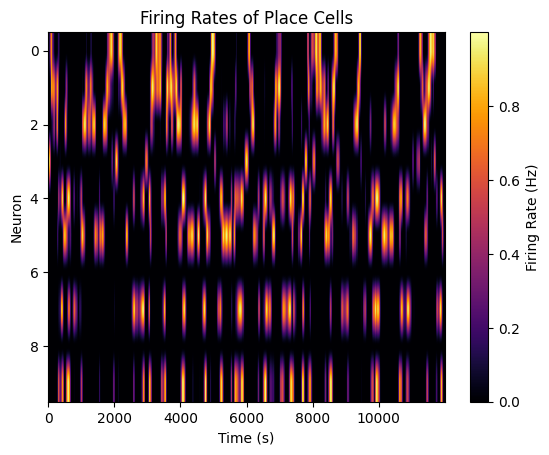

In [9]:
plt.imshow(neural_data_df.T, aspect="auto", cmap="inferno")
plt.xlabel("Time (s)")
plt.ylabel("Neuron")
plt.title("Firing Rates of Place Cells")
plt.colorbar(label="Firing Rate (Hz)")
plt.show()

### Section 1.3: Train Linear and Gaussian Process Decoders

Train simple decoders for baseline comparison with DNN decoders:

For best practices, it is important to always compare the performance of the
DNN decoders with simpler models to ensure that the additional complexity is
justified.

#### Section 1.3.1: Linear Decoder (Ridge Regression)

In [10]:
ridge = sklearn.linear_model.Ridge(alpha=0.01)
ridge.fit(train_neural, train_trajectory)
ridge.score(test_neural, test_trajectory)

0.7262108789743416

#### Section 1.3.2: Gaussian Process (GP) Decoder

In [11]:
# Initialise and fit model
model_GP = sklearn.gaussian_process.GaussianProcessRegressor(
    alpha=0.01,
    kernel=sklearn.gaussian_process.kernels.RBF(
        1
        * np.sqrt(
            N_NEURONS / 20
        ),  # <-- kernel size scales with typical input size ~sqrt(N)
        length_scale_bounds="fixed",
    ),
)
model_GP.fit(train_neural, train_trajectory)
model_GP.score(test_neural, test_trajectory)

0.8795175641295223

### Section 1.4: Train and Evaluate the DNN Decoder

Set up the decoder model and hyperparameters. For example, use an MLP decoder.

We refer description of key hyperparameters that impact model performance:

In [12]:
help(npy.ensemble.decoding.train_model)

Help on function train_model in module neuro_py.ensemble.decoding.pipeline:

train_model(partitions, hyperparams, resultspath=None, stop_partition=None)
    Generic function to train a DNN model on the given data partitions.
    
    Parameters
    ----------
    partitions : array-like
        K-fold partitions of the data with the following format:
        [(nsv_train, bv_train, nsv_val, bv_val, nsv_test, bv_test), ...]
        Each element of the list is a tuple of numpy arrays containing the with
        pairs of neural state vectors and behavioral variables for the training,
        validation, and test sets. Each array has the shape
        (ntrials, nbins, nfeats) where nfeats is the number of neurons for the
        neural state vectors and number of behavioral features to be predicted
        for the behavioral variables.
    hyperparams : dict
        Dictionary containing the hyperparameters for the model training. The
        dictionary should contain the following keys:
  

In [13]:
decoder_type = "MLP"  # Select decoder type (e.g., MLP)
hyperparams = dict(
    batch_size=512 * 4,
    num_workers=5,
    model=decoder_type,
    model_args=dict(
        in_dim=train_neural.shape[1],
        out_dim=train_trajectory.shape[1],
        hidden_dims=[64, 32, 16, 8],
        args=dict(
            clf=False,
            activations=nn.CELU,
            criterion=F.mse_loss,
            epochs=10,
            lr=3e-2,
            base_lr=1e-2,
            max_grad_norm=1.0,
            iters_to_accumulate=1,
            weight_decay=1e-2,
            num_training_batches=None,
            scheduler_step_size_multiplier=1,
        ),
    ),
    behaviors=[0, 1],
    bins_before=0,
    bins_current=1,
    bins_after=0,
    device=DEVICE,
    seed=SEED,
)

Train the decoder using the `train_model` function:

In [14]:
partitions = [
    (
        train_neural,
        train_trajectory,
        test_neural,
        test_trajectory,
        test_neural,
        test_trajectory,
    )
]

# Train the model using the pipeline function from your decoder module
results_path = None  # checkpoints will be saved to this path, optimizing reruns
bv_preds_folds, bv_models_folds, norm_params_folds, metrics_folds = (
    npy.ensemble.decoding.train_model(partitions, hyperparams, resultspath=results_path)
)

Seed set to 2025
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080 SUPER') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | main | Sequential | 3.5 K  | train
--------------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     T

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.011781885288655758    │
└───────────────────────────┴───────────────────────────┘

Variance weighed avg. coefficient of determination: 0.8003649387327375
RMSE: 0.09671944566294162


### Section 1.5: Visualize Results

Plot predictions versus ground truth to evaluate decoding performance:

/tmp/ipykernel_1782887/1205989260.py:39: UserWarning: The figure layout has changed to tight


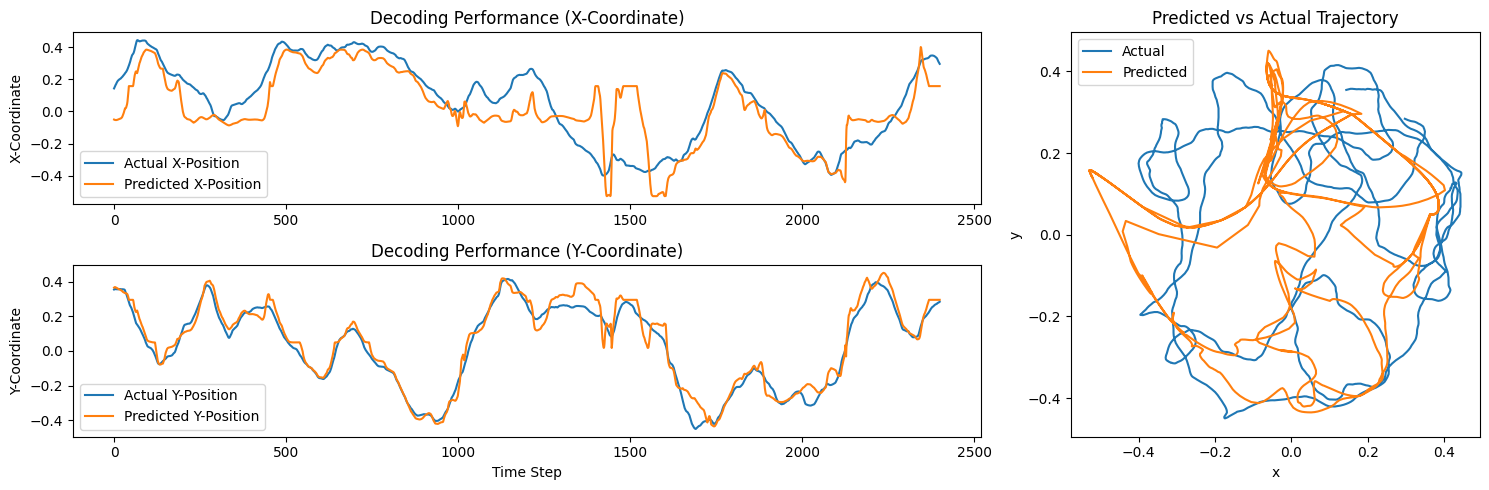

In [15]:
predicted_x = bv_preds_folds[0][:, 0]
predicted_y = bv_preds_folds[0][:, 1]
true_x = test_trajectory["x"].values
true_y = test_trajectory["y"].values

# Plotting
figsize = (15, 5)

fig = plt.figure(figsize=figsize, constrained_layout=True)
nrows, ncols = 2, 3
gs = mpl.gridspec.GridSpec(
    *(nrows, ncols), figure=fig
)  # , height_ratios=[.5] * nrows, width_ratios=[.1]*ncols)

ax = fig.add_subplot(gs[0, 0:2])
# X-coordinate plot
ax.plot(true_x, label="Actual X-Position")
ax.plot(predicted_x, label="Predicted X-Position")
ax.set_ylabel("X-Coordinate")
ax.set_title("Decoding Performance (X-Coordinate)")
ax.legend()

ax = fig.add_subplot(gs[1, 0:2])
# Y-coordinate plot
ax.plot(true_y, label="Actual Y-Position")
ax.plot(predicted_y, label="Predicted Y-Position")
ax.set_xlabel("Time Step")
ax.set_ylabel("Y-Coordinate")
ax.set_title("Decoding Performance (Y-Coordinate)")
ax.legend()


ax = fig.add_subplot(gs[:, 2])
ax.plot(*partitions[0][-1].to_numpy().T, label="Actual")
ax.plot(*bv_preds_folds[0].T, label="Predicted")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Predicted vs Actual Trajectory")
ax.legend()

plt.tight_layout()
plt.show()

The results of decoding using DNNs are not that greater than the linear and GP
decoders. This is because the data is cleanly simulated and the DNN is overkill
for this task. However, in real data, the DNN decoder will likely outperform the
linear and GP decoders.

## Section 2: Trial Segmented Decoding

Before we move on to real neural data, let's first understand how to decode
neural data in a trial-segmented manner. This is useful when the neural data is
segmented into trials, and we want to decode each trial separately.

### Section 2.1: Generate Synthetic Trial Segmented Data

Agent initialized in Cheeseboard Maze: [-0.24221668  0.15734778]


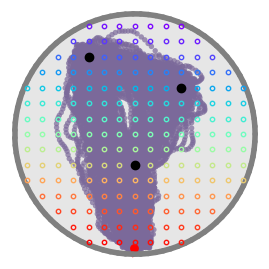

In [16]:
environment, reward_indices = create_cheeseboard_maze()

agent = rbx.Agent(environment)
init_pos = np.asarray([0, -0.48])
print(f"Agent initialized in Cheeseboard Maze: {agent.pos}")

N_NEURONS = 50
N_TRIALS = 100
placecells = PlaceCells(
    agent,
    params=dict(
        description="gaussian_threshold",
        widths=0.3,
        n=N_NEURONS,
        color="C1",
        wall_geometry="line_of_sight",
    ),
)

checkpts_coords = [
    environment.objects["objects"][reward_idx] for reward_idx in reward_indices
]
checkpts_coords = [init_pos] + checkpts_coords + [init_pos]

trial_epochs = []
trial_epoch = []
for n in range(N_TRIALS):
    for goal_coords in checkpts_coords:
        # simulate the agent in the maze
        while True:
            dir_to_goal = goal_coords - agent.pos
            drift_vel = 3 * agent.speed_mean * dir_to_goal / np.linalg.norm(dir_to_goal)
            agent.update(drift_velocity=drift_vel)
            placecells.update()

            # if animal is close to reward, break
            if np.linalg.norm(dir_to_goal) < 0.01:
                if np.all(goal_coords == init_pos):
                    trial_epoch.append(agent.t)
                    if len(trial_epoch) == 2:
                        trial_epochs.append(trial_epoch)
                        trial_epoch = []
                break

agent.plot_trajectory(trial_epochs[0][0], trial_epochs[-1][1], linewidth=1)
# plot rewards
for i in reward_indices:
    plt.plot(*environment.objects["objects"][i], "ko")

### Section 2.2: Prepare Data for Decoding

In [17]:
nsv_trials = []
bv_trials = []
for t_start, t_end in trial_epochs:
    t = np.array(placecells.history["t"])
    i_start = 0 if t_start is None else np.argmin(np.abs(t - t_start))
    i_end = -1 if t_end is None else np.argmin(np.abs(t - t_end))
    t = t[i_start:i_end]  # subsample data for training (most of it is redundant anyway)
    neural_data = np.array(placecells.history["firingrate"])[i_start:i_end]
    # Inject some noise to the neural data
    noise = np.random.normal(0, 0.1, neural_data.shape)
    neural_data += noise
    nsv_trials.append(pd.DataFrame(neural_data))
    trajectory = np.array(placecells.Agent.history["pos"])[i_start:i_end]
    bv_trials.append(pd.DataFrame(trajectory))
nsv_trials = np.asarray(nsv_trials, dtype=object)
bv_trials = np.asarray(bv_trials, dtype=object)

In [18]:
def visualize_trial(t=0):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(nsv_trials[t].to_numpy().T, aspect="auto", cmap="inferno")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Neuron")
    ax[0].set_title("Firing Rates of Cells")

    environment.plot_environment(fig, ax=ax[1])
    ax[1].plot(*bv_trials[t].to_numpy().T, label="Position")
    # plot rewards
    ax[1].plot(*environment.objects["objects"][reward_indices].T, "ko", label="Reward")
    ax[1].set_xlabel("x")
    ax[1].set_xlabel("y")
    ax[1].set_title("Trajectory")
    # plot first 2 legend only
    ax[1].legend()
    plt.show()


widgets.interact(visualize_trial, t=(0, len(nsv_trials) - 1, 1));

interactive(children=(IntSlider(value=0, description='t', max=99), Output()), _dom_classes=('widget-interact',…

In [19]:
fold_indices = npy.ensemble.decoding.split_data(
    nsv_trials, np.random.randint(0, 2, size=len(nsv_trials)), 0.6
)
partition_indices = npy.ensemble.decoding.partition_indices(fold_indices)
partitions = npy.ensemble.decoding.partition_sets(
    partition_indices, nsv_trials, bv_trials
)

### Section 2.3: Train Linear Decoder

Although Gaussian Process decoders can also be used for trial-segmented decoding,
it is computationally expensive. Here, we will use only a linear decoder for
simplicity.

In [20]:
bv_test_pred_ridge = []
for nsv_train, bv_train, nsv_val, bv_val, nsv_test, bv_test in partitions:
    ridge = sklearn.linear_model.Ridge(alpha=0.01)
    ridge.fit(np.concatenate(nsv_train), np.concatenate(bv_train))
    bv_test_pred = ridge.predict(np.concatenate(nsv_test))
    bv_test_pred_ridge.append(bv_test_pred)

sklearn.metrics.r2_score(
    np.concatenate([np.concatenate(p[-1]) for p in partitions]),
    np.concatenate(bv_test_pred_ridge),
)

0.9649046060749725

### Section 2.4: Train and Evaluate the DNN Decoder

In [21]:
decoder_type = "MLP"  # Select decoder type (e.g., MLP)
hyperparams = dict(
    batch_size=512 * 4,
    num_workers=5,
    model=decoder_type,
    model_args=dict(
        in_dim=nsv_trials[0].shape[1],
        out_dim=bv_trials[0].shape[1],
        hidden_dims=[64, 32, 16, 8],
        args=dict(
            clf=False,
            activations=nn.CELU,
            criterion=F.mse_loss,
            epochs=10,
            lr=3e-2,
            base_lr=1e-2,
            max_grad_norm=1.0,
            iters_to_accumulate=1,
            weight_decay=1e-2,
            num_training_batches=None,
            scheduler_step_size_multiplier=1,
        ),
    ),
    behaviors=[0, 1],
    bins_before=0,
    bins_current=1,
    bins_after=0,
    device=DEVICE,
    seed=SEED,
)

In [22]:
# Train the model using the pipeline function from your decoder module
results_path = "results"
bv_preds_folds, bv_models_folds, norm_params_folds, metrics_folds = (
    npy.ensemble.decoding.train_model(partitions, hyperparams, resultspath=results_path)
)

Seed set to 2025
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | main | Sequential | 6.0 K  | train
--------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0005353732849471271   │
└───────────────────────────┴───────────────────────────┘

Seed set to 2025
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cornell/Desktop/neuro_py/tutorials/results/models/2642124120 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | main | Sequential | 6.0 K  | train
--------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Variance weighed avg. coefficient of determination: 0.9880966030454236
RMSE: 0.023135812839817575


`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.000487027718918398    │
└───────────────────────────┴───────────────────────────┘

Seed set to 2025
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cornell/Desktop/neuro_py/tutorials/results/models/2642124120 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | main | Sequential | 6.0 K  | train
--------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Variance weighed avg. coefficient of determination: 0.9887515784011035
RMSE: 0.022055599437938077


`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0005021715769544244   │
└───────────────────────────┴───────────────────────────┘

Seed set to 2025
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cornell/Desktop/neuro_py/tutorials/results/models/2642124120 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | main | Sequential | 6.0 K  | train
--------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Variance weighed avg. coefficient of determination: 0.9879894805486882
RMSE: 0.02239556298226532


`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0005372166051529348   │
└───────────────────────────┴───────────────────────────┘

Seed set to 2025
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cornell/Desktop/neuro_py/tutorials/results/models/2642124120 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | main | Sequential | 6.0 K  | train
--------------------------------------------
6.0 K     Trainable params
0         Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Variance weighed avg. coefficient of determination: 0.987543710812684
RMSE: 0.02316057034376892


`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0006134471041150391   │
└───────────────────────────┴───────────────────────────┘

Variance weighed avg. coefficient of determination: 0.9855258951120814
RMSE: 0.024758977393035616


### Section 2.5: Visualize Results

In [23]:
bv_preds_dnn_trials = np.concatenate(
    [
        bv_preds_fold + norm_params_folds[i]["y_train_mean"]
        for i, bv_preds_fold in enumerate(bv_preds_folds)
    ]
)
bv_preds_ridge_trials = np.concatenate(bv_test_pred_ridge)
bv_actual_trials = np.concatenate([np.concatenate(p[-1]) for p in partitions])
trial_lengths = [len(trial) for p in partitions for trial in p[-1]]
trial_indices = np.cumsum(trial_lengths)

bv_preds_dnn_trials = np.split(bv_preds_dnn_trials, trial_indices[:-1])
bv_preds_ridge_trials = np.split(bv_preds_ridge_trials, trial_indices[:-1])
bv_actual_trials = np.split(bv_actual_trials, trial_indices[:-1])


def visualize_predicted_trial(trial=0):
    # Plotting
    figsize = (15, 5)

    fig = plt.figure(figsize=figsize)
    nrows, ncols = 2, 4
    gs = mpl.gridspec.GridSpec(
        *(nrows, ncols), figure=fig
    )  # , height_ratios=[.5] * nrows, width_ratios=[.1]*ncols)

    ax = fig.add_subplot(gs[0, 0:2])
    # X-coordinate plot
    ax.plot(bv_actual_trials[trial][:, 0], label="Actual X-Position")
    ax.plot(bv_preds_ridge_trials[trial][:, 0], label="Ridge Predicted X-Position")
    ax.plot(
        bv_preds_dnn_trials[trial][:, 0], label=f"{decoder_type} Predicted X-Position"
    )
    ax.set_ylabel("X-Coordinate")
    ax.set_title("Decoding Performance (X-Coordinate)")
    ax.legend()

    ax = fig.add_subplot(gs[1, 0:2])
    # Y-coordinate plot
    ax.plot(bv_actual_trials[trial][:, 1], label="Actual Y-Position")
    ax.plot(bv_preds_ridge_trials[trial][:, 1], label="Ridge Predicted Y-Position")
    ax.plot(
        bv_preds_dnn_trials[trial][:, 1], label=f"{decoder_type} Predicted Y-Position"
    )
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Y-Coordinate")
    ax.set_title("Decoding Performance (Y-Coordinate)")
    ax.legend()

    ax = fig.add_subplot(gs[:, 2:])
    environment.plot_environment(fig, ax=ax)
    ax.plot(*bv_actual_trials[trial].T, label="Actual")
    ax.plot(*bv_preds_ridge_trials[trial].T, label="Ridge Predicted")
    ax.plot(*bv_preds_dnn_trials[trial].T, label=f"{decoder_type} Predicted")
    # plot rewards
    ax.plot(*environment.objects["objects"][reward_indices].T, "ko", label="Reward")
    ax.set_title("Trajectory")
    # plot first 2 legend only
    ax.legend()
    plt.show()


widgets.interact(visualize_predicted_trial, trial=(0, len(nsv_trials) - 1, 1));

interactive(children=(IntSlider(value=0, description='trial', max=99), Output()), _dom_classes=('widget-intera…

## Section 3: Decoding Real Data

Now that we've seen how to decode synthetic data, let's try decoding real data.

### Section 3.1: Load the data

In [24]:
BIN_SIZE = 0.05

In [25]:
basepath = r"/run/user/1000/gvfs/smb-share:server=132.236.112.212,share=ayadata1/Data/GrosmarkAD/Achilles/Achilles_10252013"

epoch_df = npy.io.load_epoch(basepath)
# get session bounds to provide support
session_bounds = nel.EpochArray(
    [epoch_df.startTime.iloc[0], epoch_df.stopTime.iloc[-1]]
)
# compress repeated sleep sessions
epoch_df = npy.session.compress_repeated_epochs(epoch_df)
beh_epochs = nel.EpochArray(epoch_df[["startTime", "stopTime"]].values.astype(float))

st, cell_metrics = npy.io.load_spikes(
    basepath, putativeCellType="Pyr", brainRegion="CA1"
)
spike_spindices = npy.spikes.get_spindices(st.data)

swr = npy.io.load_ripples_events(basepath, return_epoch_array=True)

theta = nel.EpochArray(npy.io.load_SleepState_states(basepath)["THETA"])

task_idx = npy.process.in_intervals(
    spike_spindices.spike_times, (beh_epochs[1] & theta).data
)

In [26]:
position_df = npy.io.load_animal_behavior(basepath)

# put position into a nelpy position array for ease of use
posx = nel.AnalogSignalArray(
    data=position_df["x"].values.T,
    timestamps=position_df.timestamps.values,
)
posy = nel.AnalogSignalArray(
    data=position_df["y"].values.T,
    timestamps=position_df.timestamps.values,
)

# get outbound and inbound epochs
(outbound_epochs, inbound_epochs) = npy.behavior.get_linear_track_lap_epochs(
    posx.abscissa_vals, posx.data[0], newLapThreshold=20
)

outbound_epochs, inbound_epochs

(<EpochArray at 0x789e1bba5fa0: 42 epochs> of length 17:07:964 minutes,
 <EpochArray at 0x789e1bba5160: 43 epochs> of length 17:17:974 minutes)

### Section 3.2: Prepare Data for Decoding

In [27]:
bst_trials_inbound = [
    st[i].bin(ds=BIN_SIZE).smooth(sigma=BIN_SIZE, inplace=True) for i in outbound_epochs
]
bst_trials_outbound = [
    st[i].bin(ds=BIN_SIZE).smooth(sigma=BIN_SIZE, inplace=True) for i in inbound_epochs
]
bst_trials = bst_trials_inbound + bst_trials_outbound
nsv_trials = np.asarray([pd.DataFrame(i.data.T) for i in bst_trials], dtype=object)

In [28]:
pos_trials_with_missing = [
    np.vstack(
        (
            posx.asarray(at=bst.bin_centers).yvals[0],
            posy.asarray(at=bst.bin_centers).yvals[0],
        )
    )
    for bst in bst_trials
]

pos_trials = []
for p in pos_trials_with_missing:
    p = pd.DataFrame(p.T)

    # find max contiguous sequence of NaNs
    max_len_nan = 0
    max_nan = 0
    for i in range(len(p)):
        if pd.isna(p.iloc[i, 0]):
            max_nan += 1
        else:
            max_len_nan = max(max_len_nan, max_nan)
            max_nan = 0
    max_len_nan += 1

    # fill missing values mean of surrounding values
    p = p.fillna(p.rolling(max_len_nan, min_periods=1).mean())

    # fill left edge nan values with first non-nan value
    p = p.ffill().bfill()
    pos_trials.append(p.values)
pos_trials = np.asarray(pos_trials, dtype=object)

In [29]:
# Format partitions for the decoder pipeline
fold_indices = npy.ensemble.decoding.split_data(
    nsv_trials, np.random.randint(0, 2, size=len(nsv_trials)), 0.6
)
partition_indices = npy.ensemble.decoding.partition_indices(fold_indices)
partitions = npy.ensemble.decoding.partition_sets(
    partition_indices, nsv_trials, pos_trials
)

### Section 3.3: Train Linear Decoder

In [30]:
bv_test_pred_ridge = []
for nsv_train, bv_train, nsv_val, bv_val, nsv_test, bv_test in partitions:
    ridge = sklearn.linear_model.Ridge(alpha=0.01)
    ridge.fit(np.concatenate(nsv_train), np.concatenate(bv_train))
    bv_test_pred = ridge.predict(np.concatenate(nsv_test))
    bv_test_pred_ridge.append(bv_test_pred)

sklearn.metrics.r2_score(
    np.concatenate([np.concatenate(p[-1]) for p in partitions]),
    np.concatenate(bv_test_pred_ridge),
)

0.4274710535820969

### Section 3.4: Train and Evaluate the DNN Decoder

In [31]:
decoder_type = "MLP"  # Select decoder type (e.g., MLP)
hyperparams = dict(
    batch_size=512 * 8,
    num_workers=5,
    model=decoder_type,
    model_args=dict(
        in_dim=nsv_trials[0].shape[1],
        out_dim=pos_trials[0].shape[1],
        hidden_dims=[256, 256, 0.15, 256],
        args=dict(
            clf=False,
            activations=nn.CELU,
            criterion=F.mse_loss,
            epochs=40,
            lr=3e-2,
            base_lr=1e-2,
            max_grad_norm=1.0,
            iters_to_accumulate=1,
            weight_decay=1e-2,
            num_training_batches=None,
            scheduler_step_size_multiplier=1,
        ),
    ),
    behaviors=[0, 1],
    bins_before=1,
    bins_current=1,
    bins_after=0,
    device=DEVICE,
    seed=SEED,
)

In [32]:
# Train the model using the pipeline function from your decoder module
results_path = "results"
bv_preds_folds, bv_models_folds, norm_params_folds, metrics_folds = (
    npy.ensemble.decoding.train_model(partitions, hyperparams, resultspath=results_path)
)

Seed set to 2025
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | main | Sequential | 255 K  | train
--------------------------------------------
255 K     Trainable params
0         Non-trainable params
255 K     Total params
1.023     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=40` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     861.2627563476562     │
└───────────────────────────┴───────────────────────────┘

Seed set to 2025
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cornell/Desktop/neuro_py/tutorials/results/models/1990776941 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | main | Sequential | 255 K  | train
--------------------------------------------
255 K     Trainable params
0         Non-trainable params
255 K     Total params
1.023     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Variance weighed avg. coefficient of determination: 0.6773325030958686
RMSE: 24.213068433497135


`Trainer.fit` stopped: `max_epochs=40` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      1386.150390625       │
└───────────────────────────┴───────────────────────────┘

Seed set to 2025
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cornell/Desktop/neuro_py/tutorials/results/models/1990776941 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | main | Sequential | 255 K  | train
--------------------------------------------
255 K     Trainable params
0         Non-trainable params
255 K     Total params
1.023     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Variance weighed avg. coefficient of determination: 0.46727911396418176
RMSE: 32.120959673056355


`Trainer.fit` stopped: `max_epochs=40` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      1221.5458984375      │
└───────────────────────────┴───────────────────────────┘

Seed set to 2025
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cornell/Desktop/neuro_py/tutorials/results/models/1990776941 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | main | Sequential | 255 K  | train
--------------------------------------------
255 K     Trainable params
0         Non-trainable params
255 K     Total params
1.023     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Variance weighed avg. coefficient of determination: 0.6286478191387428
RMSE: 28.07934763958197


`Trainer.fit` stopped: `max_epochs=40` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     650.6585693359375     │
└───────────────────────────┴───────────────────────────┘

Seed set to 2025
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cornell/Desktop/neuro_py/tutorials/results/models/1990776941 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/cornell/.conda/envs/pfc/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | main | Sequential | 255 K  | train
--------------------------------------------
255 K     Trainable params
0         Non-trainable params
255 K     Total params
1.023     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Variance weighed avg. coefficient of determination: 0.7983677020380157
RMSE: 21.3463354244628


`Trainer.fit` stopped: `max_epochs=40` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     786.2012939453125     │
└───────────────────────────┴───────────────────────────┘

Variance weighed avg. coefficient of determination: 0.6337113438298102
RMSE: 23.376468307662268


### Section 3.5: Visualize Results

In [33]:
bv_preds_dnn_trials = np.concatenate(
    [
        bv_preds_fold + norm_params_folds[i]["y_train_mean"]
        for i, bv_preds_fold in enumerate(bv_preds_folds)
    ]
)
bv_preds_ridge_trials = np.concatenate(bv_test_pred_ridge)
bv_actual_trials = np.concatenate([np.concatenate(p[-1]) for p in partitions])
trial_lengths = [len(trial) for p in partitions for trial in p[-1]]
trial_indices = np.cumsum(trial_lengths)

bv_preds_dnn_trials = np.split(bv_preds_dnn_trials, trial_indices[:-1])
bv_preds_ridge_trials = np.split(bv_preds_ridge_trials, trial_indices[:-1])
bv_actual_trials = np.split(bv_actual_trials, trial_indices[:-1])


def visualize_predicted_trial(trial=0):
    # Plotting
    figsize = (15, 5)

    fig = plt.figure(figsize=figsize)
    nrows, ncols = 2, 3
    gs = mpl.gridspec.GridSpec(
        *(nrows, ncols), figure=fig
    )  # , height_ratios=[.5] * nrows, width_ratios=[.1]*ncols)

    ax = fig.add_subplot(gs[0, 0:2])
    # X-coordinate plot
    ax.plot(bv_actual_trials[trial][:, 0], label="Actual X-Position")
    ax.plot(
        bv_preds_ridge_trials[trial][:, 0],
        label="Ridge Predicted X-Position",
        alpha=0.75,
    )
    ax.plot(
        bv_preds_dnn_trials[trial][:, 0],
        label=f"{decoder_type} Predicted X-Position",
        alpha=0.75,
    )
    ax.set_ylabel("X-Coordinate")
    ax.set_title("Decoding Performance (X-Coordinate)")
    ax.legend()

    ax = fig.add_subplot(gs[1, 0:2])
    # Y-coordinate plot
    ax.plot(bv_actual_trials[trial][:, 1], label="Actual Y-Position")
    ax.plot(
        bv_preds_ridge_trials[trial][:, 1],
        label="Ridge Predicted Y-Position",
        alpha=0.75,
    )
    ax.plot(
        bv_preds_dnn_trials[trial][:, 1],
        label=f"{decoder_type} Predicted Y-Position",
        alpha=0.75,
    )
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Y-Coordinate")
    ax.set_title("Decoding Performance (Y-Coordinate)")
    ax.legend()

    ax = fig.add_subplot(gs[:, 2])
    ax.plot(*bv_actual_trials[trial].T, label="Actual")
    ax.plot(*bv_preds_ridge_trials[trial].T, label="Ridge Predicted", alpha=0.75)
    ax.plot(
        *bv_preds_dnn_trials[trial].T, label=f"{decoder_type} Predicted", alpha=0.75
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Trajectory")
    ax.legend()

    plt.tight_layout()
    plt.show()


widgets.interact(visualize_predicted_trial, trial=(0, len(nsv_trials) - 1, 1));

interactive(children=(IntSlider(value=0, description='trial', max=84), Output()), _dom_classes=('widget-intera…

---